In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import os
from glob import glob

import seaborn as sns
from matplotlib import pyplot as plt
from samecode.survival.plot import KMPlot
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index as lfcindex

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)

In [2]:
y = pd.read_csv('../Clinical_Transformer/data/ITRP_clinical.csv', index_col=0)
y = y[(~y.OS_Months.isna()) & (~y.OS_Event.isna()) ] # & (~y.TMB.isna())
y['time'] = y['OS_Months']
y['event'] = y['OS_Event']

s = y.cohort.value_counts()
s = s.index + '(n=' + s.astype(str) + ')'

In [3]:
k = y[(~y.OS_Months.isna()) & (~y.OS_Event.isna()) & (~y.TMB.isna()) ] # 
k = k.cohort.value_counts()
k.index + '(n=' + k.astype(str) + ')'

IMVigor210    IMVigor210(n=234)
Liu                  Liu(n=107)
Rose                 Rose(n=88)
SU2CLC1           SU2CLC1(n=51)
Riaz                 Riaz(n=46)
Allen               Allen(n=39)
MGH                   MGH(n=28)
Hugo                 Hugo(n=25)
SU2CLC2           SU2CLC2(n=10)
dtype: object

In [4]:
def read_fd_csvs(csv_reg, cohort, model_name,  learning_type):
    csvs = glob(csv_reg)
    res = []
    for csv in csvs:
        fd = int(csv.split('/')[-2].split('-')[-1])
        df = pd.read_csv(csv)
        df = df[['epoch','val_sigmoid_concordance']]
        df['fold'] = fd
        df['cohort'] = cohort
        df['model_name'] = model_name
        df['learning_type'] = learning_type
        res.append(df)
    return pd.concat(res)

In [5]:
Model_NAMES = ['Vanilla Clinical Transformer',
              'ssGSEA43 + Clinical Transformer',
              'COMPASS + Clinical Transformer',]

Model_PATHS = ['VanillaClinicalTransformer',
              'ssGSEA43ClinicalTransformer',
              'COMPASSClinicalTransformer',]

Learning_TYPES = ['Baseline Survival Model', 'Transfer Learning Survival Model']
Learning_FILES = ['ResultsBaseline', 'ResultsTransferLearning']
ci = 60

cohort_list_all = ['IMVigor210','Liu', 'SU2CLC1','SU2CLC2','Rose', 
                   'Snyder','Hugo', 'Gide', 'Riaz', 'Allen', 'MGH']

In [6]:
res = []
for cohort in cohort_list_all:
    for i in range(3):
        model_name = Model_NAMES[i]
        mpt = Model_PATHS[i]
        for j in range(2):
            learning_type = Learning_TYPES[j]
            fpt = Learning_FILES[j]        
            if learning_type != Learning_TYPES[1]:
                p = f'../Clinical_Transformer/04_Clinical_Transformer/Results/{fpt}/{mpt}/{cohort}/*/history.csv'
            else:
                p = f'../Clinical_Transformer/04_Clinical_Transformer/Results/{fpt}/{mpt}/{cohort}/*/*/history.csv'

            df = read_fd_csvs(p, cohort = cohort, 
                       model_name = model_name, 
                       learning_type = learning_type)
            res.append(df)
dfp_all = pd.concat(res)

dfp_all.to_excel(f'./results/All_ClinicalTransformer_validation.xlsx')

In [7]:
mychort_list =  cohort_list_all #['IMVigor210', 'Liu', 'SU2CLC1']

In [8]:
dfp = dfp_all #[dfp_all.cohort.isin(mychort_list)]

In [9]:
dfp.cohort.unique()

array(['IMVigor210', 'Liu', 'SU2CLC1', 'SU2CLC2', 'Rose', 'Snyder',
       'Hugo', 'Gide', 'Riaz', 'Allen', 'MGH'], dtype=object)

In [10]:
mean = dfp.groupby([ 'learning_type', 'model_name', 'cohort', 'epoch']).val_sigmoid_concordance.mean()
std = dfp.groupby([ 'learning_type', 'model_name', 'cohort', 'epoch']).val_sigmoid_concordance.std()



best_e = mean.reset_index().set_index('epoch').groupby(['learning_type', 'model_name', 
                                                        'cohort']).val_sigmoid_concordance.idxmax()
best_e_index = best_e.to_frame(name= 'epoch').reset_index().set_index([ 'learning_type', 
                                                                       'model_name', 'cohort', 'epoch']).index


In [11]:
y = mean.reset_index().groupby(['learning_type', 'model_name', 'cohort']).val_sigmoid_concordance.max().unstack()
y_std = std.loc[best_e_index].reset_index().set_index(['learning_type', 
                                                       'model_name', 
                                                       'cohort']).val_sigmoid_concordance.unstack()

perforamnce = y.round(3).astype(str) + '±' + y_std.round(3).astype(str)
perforamnce = perforamnce[mychort_list]
perforamnce.columns = perforamnce.columns.map(s.to_dict())

a1 = y.mean(axis=1).to_frame(name = 'mean')
a2 = y.std(axis=1).to_frame(name = 'mean')
a = a1.round(3).astype(str) + '±' + a2.round(3).astype(str)

perforamnce = perforamnce.join(a).T

In [12]:
perforamnce.to_excel(f'./results/Summary_ClinicalTransformer_validation_cindex.xlsx')

In [13]:
best_e.unstack().to_excel(f'./results/Summary_ClinicalTransformer_best_epoch.xlsx')
best_e.unstack()

cohort                                                            Allen  Gide  \
learning_type                    model_name                                     
Baseline Survival Model          COMPASS + Clinical Transformer     159   299   
                                 Vanilla Clinical Transformer        76   230   
                                 ssGSEA43 + Clinical Transformer    274   238   
Transfer Learning Survival Model COMPASS + Clinical Transformer      41    47   
                                 Vanilla Clinical Transformer        74    80   
                                 ssGSEA43 + Clinical Transformer     18   128   

cohort                                                            Hugo  \
learning_type                    model_name                              
Baseline Survival Model          COMPASS + Clinical Transformer    198   
                                 Vanilla Clinical Transformer       39   
                                 ssGSEA43 + Clinical Transformer    49   
Transfer Learning Survival Model COMPASS + Clinical Transformer     90   
                                 Vanilla Clinical Transformer       40   
                                 ssGSEA43 + Clinical Transformer    14   

cohort                                                            IMVigor210  \
learning_type                    model_name                                    
Baseline Survival Model          COMPASS + Clinical Transformer          166   
                                 Vanilla Clinical Transformer            116   
                                 ssGSEA43 + Clinical Transformer         136   
Transfer Learning Survival Model COMPASS + Clinical Transformer           61   
                                 Vanilla Clinical Transformer            112   
                                 ssGSEA43 + Clinical Transformer          77   

cohort                                                            Liu  MGH  \
learning_type                    model_name                                  
Baseline Survival Model          COMPASS + Clinical Transformer   197  129   
                                 Vanilla Clinical Transformer     182  125   
                                 ssGSEA43 + Clinical Transformer  279   83   
Transfer Learning Survival Model COMPASS + Clinical Transformer    42   46   
                                 Vanilla Clinical Transformer     149   69   
                                 ssGSEA43 + Clinical Transformer  112  103   

cohort                                                            Riaz  Rose  \
learning_type                    model_name                                    
Baseline Survival Model          COMPASS + Clinical Transformer     97   184   
                                 Vanilla Clinical Transformer      173    46   
                                 ssGSEA43 + Clinical Transformer   299    40   
Transfer Learning Survival Model COMPASS + Clinical Transformer     56    78   
                                 Vanilla Clinical Transformer       75   115   
                                 ssGSEA43 + Clinical Transformer    24   113   

cohort                                                            SU2CLC1  \
learning_type                    model_name                                 
Baseline Survival Model          COMPASS + Clinical Transformer       299   
                                 Vanilla Clinical Transformer          52   
                                 ssGSEA43 + Clinical Transformer       75   
Transfer Learning Survival Model COMPASS + Clinical Transformer        72   
                                 Vanilla Clinical Transformer         165   
                                 ssGSEA43 + Clinical Transformer      101   

cohort                                                            SU2CLC2  \
learning_type                    model_name                                 
Baseline Survival Model          COMPASS + Clinical Transformer       198   
   

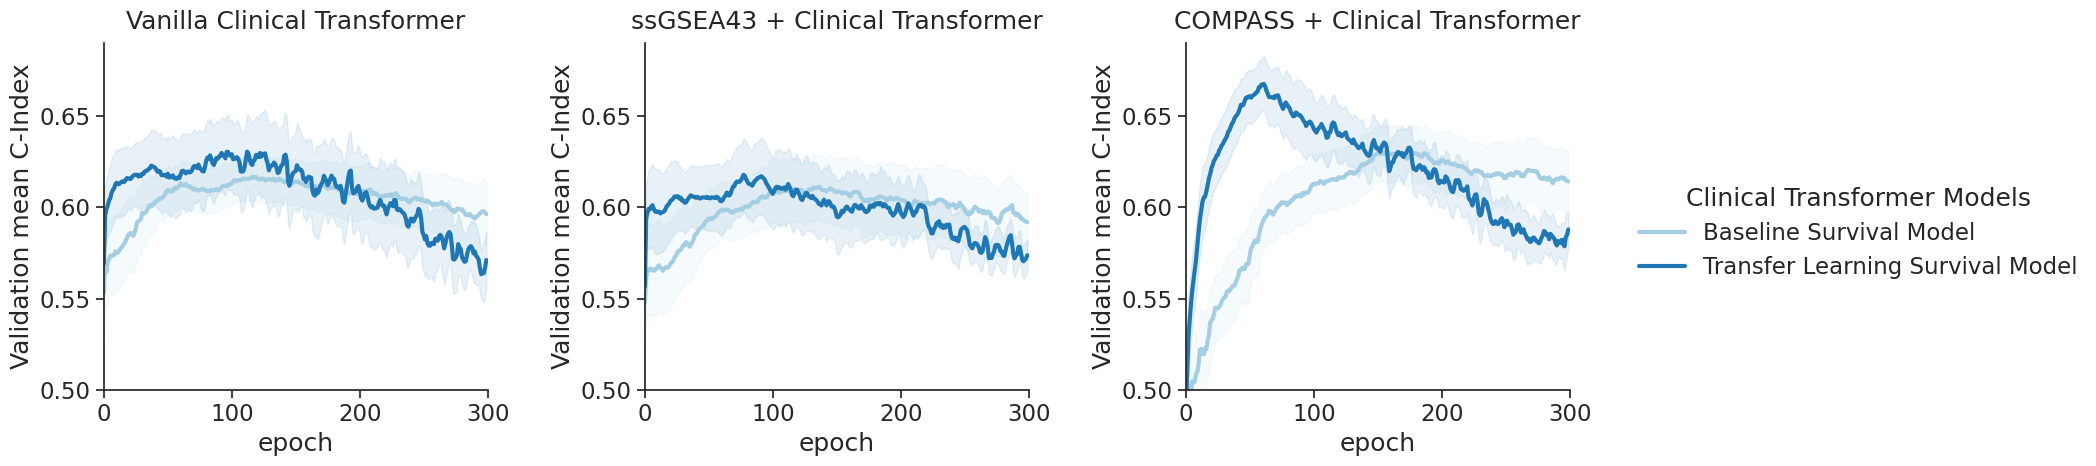

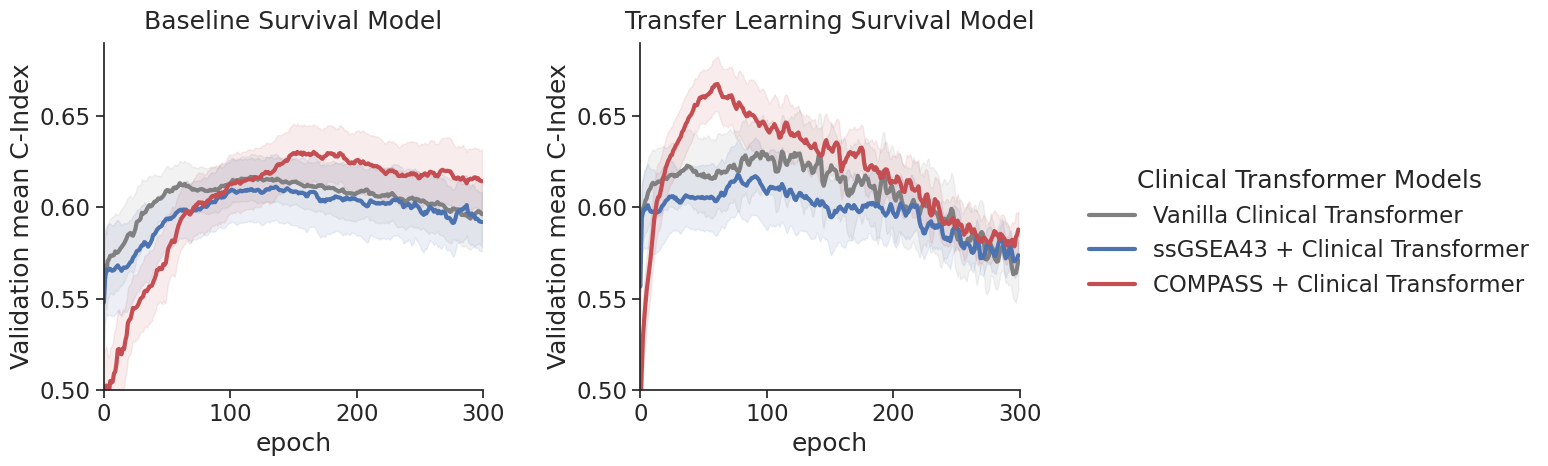

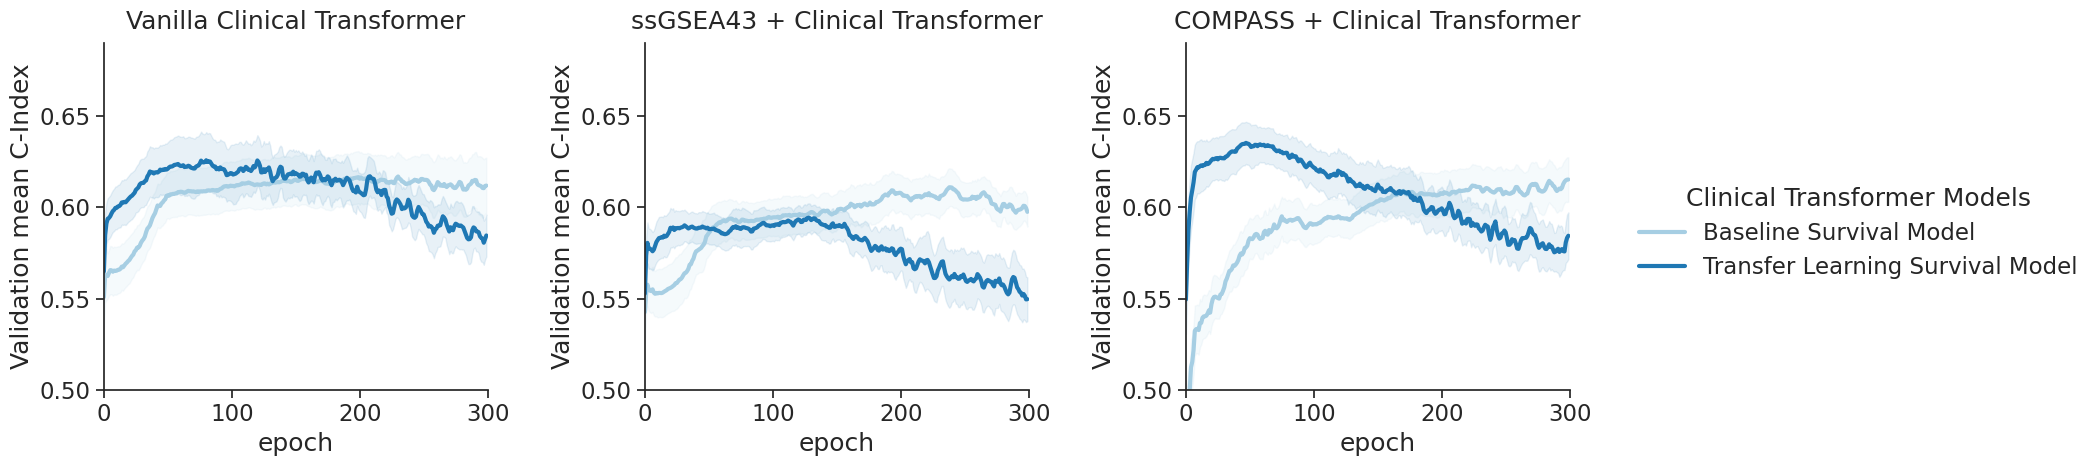

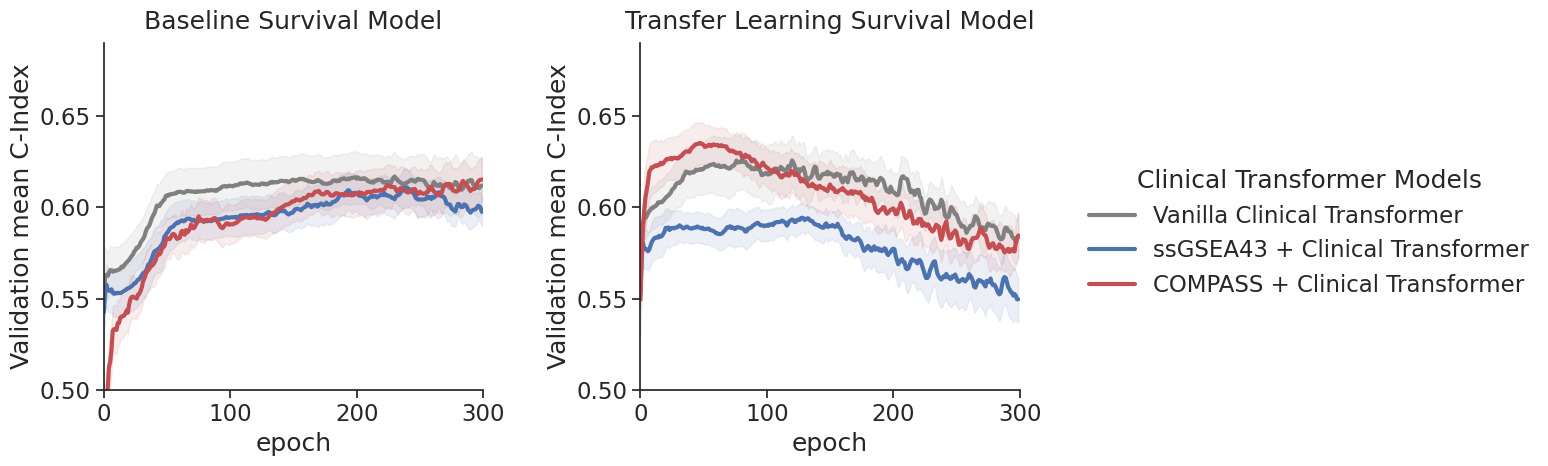

In [34]:
mychort_list = ['IMVigor210', 'Gide']
for cohort in mychort_list:

    dfp = dfp_all[dfp_all.cohort == cohort]
    fig, axes = plt.subplots(ncols=3, figsize=(5.5*3, 5), sharey=False)

    for i in range(3):
        model_name = Model_NAMES[i]
        ax = axes[i]
        data = dfp[dfp.model_name == model_name]
        sns.lineplot(
            data=data, x='epoch',
            y='val_sigmoid_concordance', lw = 3,
            hue='learning_type', ax=ax, errorbar='se', #('ci', ci)
            palette='Paired' 
        )

        for artist in ax.collections:
            if artist.__class__.__name__ == 'PolyCollection':
                artist.set_alpha(0.1)

        ax.set_ylim(0.5, 0.69)
        ax.set_xlim(0, 300)
        ax.tick_params(bottom=True, left=True)
        ax.set_ylabel('Validation mean C-Index')
        ax.set_title(model_name, pad = 10)
        sns.despine()

        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # 从第一个子图提取 handles 和 labels
    handles, labels = axes[0].get_legend_handles_labels()

    # 在 figure 右侧加一个共享 legend
    fig.legend(handles, labels,
               title="Clinical Transformer Models", 
               loc='center left',         # 锚点在右侧中间
               bbox_to_anchor=(1.0, 0.5), # (x=1.01 表示在绘图区右边外一点, y=0.5 表示垂直居中)
               frameon=False)

    plt.tight_layout()
    #plt.subplots_adjust(right=0.9)  # 给右侧留空间，避免子图被压缩得太紧

    fig.savefig(f'./results/{cohort}_ClinicalTransformer_validation_acrosslearning.svg',
                bbox_inches = 'tight')



    fig, axes = plt.subplots(ncols=2, figsize=(5.5*2, 5), sharey=False)

    for i in range(2):
        learning_type = Learning_TYPES[i]
        ax = axes[i]
        data = dfp[dfp.learning_type == learning_type]
        sns.lineplot(
            data=data, x='epoch', lw = 3,
            y='val_sigmoid_concordance', hue_order = Model_NAMES,
            hue='model_name', ax=ax, errorbar= 'se',#('ci', ci),
            palette=['grey','b', 'r']
        )

        for artist in ax.collections:
            if artist.__class__.__name__ == 'PolyCollection':
                artist.set_alpha(0.1)

        ax.set_ylim(0.5, 0.69)
        ax.set_xlim(0, 300)
        ax.tick_params(bottom=True, left=True)
        ax.set_ylabel('Validation mean C-Index')
        ax.set_title(learning_type, pad = 10)
        sns.despine()

        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # 从第一个子图提取 handles 和 labels
    handles, labels = axes[0].get_legend_handles_labels()

    # 在 figure 右侧加一个共享 legend
    fig.legend(handles, labels,
               title="Clinical Transformer Models", 
               loc='center left',         # 锚点在右侧中间
               bbox_to_anchor=(1.0, 0.5), # (x=1.01 表示在绘图区右边外一点, y=0.5 表示垂直居中)
               frameon=False)

    plt.tight_layout()
    #plt.subplots_adjust(right=0.9)  # 

    fig.savefig(f'./results/{cohort}_ClinicalTransformer_validation_acrossodel.svg',
                bbox_inches = 'tight')

/tmp/ipykernel_2561711/822913949.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labelticks, )


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Vanilla Clinical Transformer_Baseline Survival Model vs. Vanilla Clinical Transformer_Transfer Learning Survival Model: Mann-Whitney-Wilcoxon test two-sided, P_val:2.027e-03 U_stat=1.300e+01
ssGSEA43 + Clinical Transformer_Baseline Survival Model vs. ssGSEA43 + Clinical Transformer_Transfer Learning Survival Model: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=6.100e+01
COMPASS + Clinical Transformer_Baseline Survival Model vs. COMPASS + Clinical Transformer_Transfer Learning Survival Model: Mann-Whitney-Wilcoxon test two-sided, P_val:3.913e-04 U_stat=6.000e+00
Vanilla Clinical Transformer_Transfer Learning Survival Model vs. COMPASS + Clinical Transformer_Transfer Learning Survival Model: Mann-Whitney-Wilcoxon test two-sided, P_val:4.179e-02 U_stat=2.900e+01
ssGSEA43 + Clinical Tra

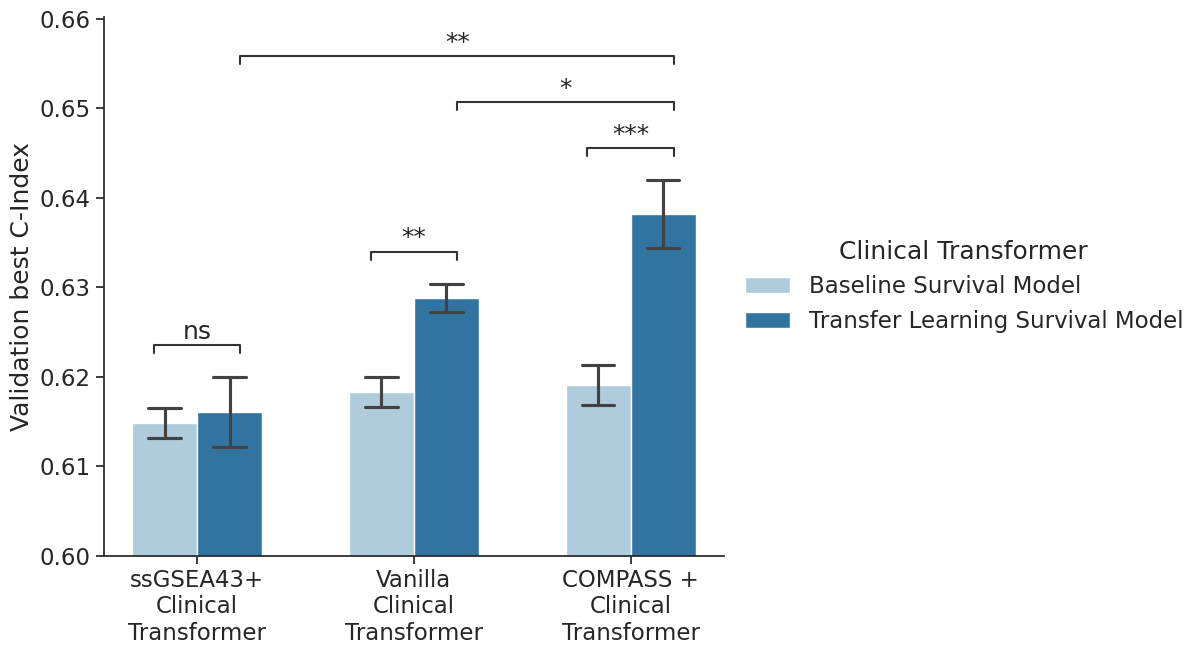

In [32]:
from statannotations.Annotator import Annotator


data = y.T.unstack().to_frame('Cindex').reset_index()

order =  [ 'ssGSEA43 + Clinical Transformer',
             'Vanilla Clinical Transformer',
              'COMPASS + Clinical Transformer',]

x_labelticks =  [ 'ssGSEA43+\nClinical\nTransformer',
             'Vanilla\nClinical\nTransformer',
              'COMPASS +\nClinical\nTransformer',]

fig, ax = plt.subplots(figsize=(8, 7), )
sns.barplot(data  = data, x = 'model_name', errorbar = 'se', 
            order = order, capsize=0.3, width = 0.6, palette='Paired',
            #legend=False,
        y = 'Cindex', hue = 'learning_type', ax=ax)


handles, labels = ax.get_legend_handles_labels()

ax.set_ylim(0.6, 0.645)
# 在 figure 右侧加一个共享 legend
ax.legend(handles, labels,
           title="Clinical Transformer", 
           loc='center left',         # 锚点在右侧中间
           bbox_to_anchor=(1.0, 0.5), # (x=1.01 表示在绘图区右边外一点, y=0.5 表示垂直居中)
           frameon=False)

ax.set_ylabel('Validation best C-Index')
ax.set_xlabel('')
sns.despine()

ax.tick_params(bottom=True, left=True)
ax.set_xticklabels(x_labelticks, )




pairs = [(('COMPASS + Clinical Transformer', 'Baseline Survival Model'),('COMPASS + Clinical Transformer', 'Transfer Learning Survival Model')),
        
         (('ssGSEA43 + Clinical Transformer', 'Baseline Survival Model'), ('ssGSEA43 + Clinical Transformer', 'Transfer Learning Survival Model')),

         (('Vanilla Clinical Transformer', 'Baseline Survival Model'), ('Vanilla Clinical Transformer', 'Transfer Learning Survival Model')),

         (('COMPASS + Clinical Transformer', 'Transfer Learning Survival Model'), 
          ('Vanilla Clinical Transformer', 'Transfer Learning Survival Model')),
         (('COMPASS + Clinical Transformer', 'Transfer Learning Survival Model'), 
          ('ssGSEA43 + Clinical Transformer', 'Transfer Learning Survival Model'))
]
annot = Annotator(
    ax, pairs,
    data=data, x='model_name', y='Cindex', hue='learning_type',
    order=order  # <- match your seaborn order
    # DO NOT pass plot='barplot'
)
annot.configure(
    test='Mann-Whitney',                 # or 'Mann-Whitney'
    #comparisons_correction='fdr_bh',
    text_format='star',
    show_test_name=False
)
annot.apply_and_annotate()


fig.savefig(f'./results/ClinicalTransformer_validation_overall_all_cohort.svg',
            bbox_inches = 'tight')